In [28]:
# first ensure that potentially required libraries are loaded
import pandas as pd
import numpy as np
import json

#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
print('Libraries imported.')

Libraries imported.


In [29]:
# Foursquare credentials
CLIENT_ID = 'LA4JOQYTDXPCZC0L5HRCWPYRQJSEVYBVMHGEUGTDNLWEIREP' # your Foursquare ID
CLIENT_SECRET = '3QINQI23F2QARVLX2JXVVPSZBTPQNWGUDCRF4UYHJ10UTAS4' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: LA4JOQYTDXPCZC0L5HRCWPYRQJSEVYBVMHGEUGTDNLWEIREP
CLIENT_SECRET:3QINQI23F2QARVLX2JXVVPSZBTPQNWGUDCRF4UYHJ10UTAS4


In [30]:

# Find the coordinates for the city hall in central Oslo
address = 'Fridtjof Nansens plass, Oslo, Norway'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)


59.91270405 10.734915487344274


In [33]:
search_query = "Coffee"
radius = 1500
print(search_query + '....OK!')
coffee_url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)


Coffee....OK!


In [34]:
coffee_results = requests.get(coffee_url).json()
#coffee_results

# assign relevant information to venues
venues = coffee_results['response']['venues']
# transform venues to a dataframe
dfv = json_normalize(venues)
dfv.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  import sys


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood
0,4b8a5f67f964a520606a32e3,People & Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1588732434,False,Akersgata 2,59.910493,10.738695,"[{'label': 'display', 'lat': 59.91049268619492...",324,0158,NO,Oslo,Oslo,Norge,"[Akersgata 2, 0158 Oslo, Norge]",NaN,NaN
1,4ff1a1ede4b01885369590ea,Wayne's Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1588732434,False,Akersgata 35,59.913270,10.741610,"[{'label': 'display', 'lat': 59.91327046962819...",378,0158,NO,Oslo,Oslo,Norge,"[Akersgata 35 (Egertorget), 0158 Oslo, Norge]",Egertorget,NaN
2,4e9d579c6c251c381df15d69,Coffee Club,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1588732434,False,NaN,59.912832,10.735162,"[{'label': 'display', 'lat': 59.91283194000694...",19,NaN,NO,Oslo,Oslo,Norge,"[Oslo, Norge]",NaN,Sentrum
3,5676c9b7498e82133a8d5b5d,coffee lounge Karl Johans gate Hotell,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1588732434,False,NaN,59.914106,10.739354,"[{'label': 'display', 'lat': 59.914106, 'lng':...",292,NaN,NO,NaN,NaN,Norge,[Norge],NaN,NaN
4,5e10a81086c49100081571fb,Erlik Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1588732434,False,NaN,59.914275,10.743098,"[{'label': 'display', 'lat': 59.914275, 'lng':...",488,0180,NO,Oslo,Oslo,Norge,"[0180 Oslo, Norge]",NaN,NaN


In [35]:
# Now for some data-wrangling. Drop the columns I don't need. 
filtered_columns = ['name', 'categories'] + [col for col in dfv.columns if col.startswith('location.')] +  ['id']
dfv_filtered = dfv.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dfv_filtered['categories'] = dfv_filtered.apply(get_category_type, axis=1)
# clean column names by keeping only last term
dfv_filtered.columns = [column.split('.')[-1] for column in dfv_filtered.columns]

dfv_filtered

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,People & Coffee,Coffee Shop,Akersgata 2,59.910493,10.738695,"[{'label': 'display', 'lat': 59.91049268619492...",324,0158,NO,Oslo,Oslo,Norge,"[Akersgata 2, 0158 Oslo, Norge]",NaN,NaN,4b8a5f67f964a520606a32e3
1,Wayne's Coffee,Coffee Shop,Akersgata 35,59.913270,10.741610,"[{'label': 'display', 'lat': 59.91327046962819...",378,0158,NO,Oslo,Oslo,Norge,"[Akersgata 35 (Egertorget), 0158 Oslo, Norge]",Egertorget,NaN,4ff1a1ede4b01885369590ea
2,Coffee Club,Café,NaN,59.912832,10.735162,"[{'label': 'display', 'lat': 59.91283194000694...",19,NaN,NO,Oslo,Oslo,Norge,"[Oslo, Norge]",NaN,Sentrum,4e9d579c6c251c381df15d69
3,coffee lounge Karl Johans gate Hotell,Café,NaN,59.914106,10.739354,"[{'label': 'display', 'lat': 59.914106, 'lng':...",292,NaN,NO,NaN,NaN,Norge,[Norge],NaN,NaN,5676c9b7498e82133a8d5b5d
4,Erlik Coffee,Coffee Shop,NaN,59.914275,10.743098,"[{'label': 'display', 'lat': 59.914275, 'lng':...",488,0180,NO,Oslo,Oslo,Norge,"[0180 Oslo, Norge]",NaN,NaN,5e10a81086c49100081571fb
5,Coffee 2 go,Café,NaN,59.911924,10.756557,"[{'label': 'display', 'lat': 59.911924, 'lng':...",1210,NaN,NO,NaN,NaN,Norge,[Norge],NaN,NaN,4bb3464542959c740fb2212c
6,Wraps & Coffee,Mexican Restaurant,Akersgata 32,59.914224,10.742800,"[{'label': 'display', 'lat': 59.9142235813742,...",471,0180,NO,Oslo,Oslo,Norge,"[Akersgata 32, 0180 Oslo, Norge]",NaN,NaN,4bb063a0f964a52088433ce3
7,Wayne's Coffee,Café,Grensen 30,59.914457,10.741382,"[{'label': 'display', 'lat': 59.91445680256309...",410,0180,NO,Oslo,Oslo,Norge,"[Grensen 30 (at Pilestredet), 0180 Oslo, Norge]",at Pilestredet,NaN,50fd5063e4b0ef4ba4a7396f
8,Heavenly Coffee,Coffee Shop,NaN,59.914240,10.752569,"[{'label': 'display', 'lat': 59.91423982661211...",999,NaN,NO,NaN,NaN,Norge,[Norge],NaN,NaN,511393c6e4b030d5b982e7cd
9,Low Carb & Coffee,Coffee Shop,NaN,59.921357,10.729137,"[{'label': 'display', 'lat': 59.921357, 'lng':...",1015,NaN,NO,NaN,NaN,Norge,[Norge],NaN,NaN,5042074de4b0ba0a528f6b88


In [36]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the City Hall

# add a red  marker to represent the City Hall
folium.Circle(
    [latitude, longitude],
    radius=20,
    color='red',
    popup='City Hall',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Coffee Shops as blue markers
for lat, lng, label in zip(dfv_filtered.lat, dfv_filtered.lng, dfv_filtered.categories):
    folium.Circle(
        [lat, lng],
        radius=15,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [37]:
categoryId = "4bf58dd8d48988d163941735" #category id for parks
#search_query2 = "Park"
popular_url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
popular_results = requests.get(popular_url).json()
# assign relevant information to the venues
popular = popular_results['response']['venues']
# transform to a dataframe
dfvp = json_normalize(popular)
dfvp.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood
0,4b0588b8f964a5206bd622e3,Spikersuppa,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1588732496,False,Karl Johans gate,Rosenkrantz gate,59.913854,10.737200,"[{'label': 'display', 'lat': 59.913854, 'lng':...",180,0161,NO,Oslo,Oslo,Norge,"[Karl Johans gate (Rosenkrantz gate), 0161 Osl...",NaN
1,4c03c44c187ec928b40cb67b,Slottsparken,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1588732496,False,Slottsparken,NaN,59.916380,10.730215,"[{'label': 'display', 'lat': 59.91638006600883...",486,0010,NO,Oslo,Oslo,Norge,"[Slottsparken, 0010 Oslo, Norge]",NaN
2,57e0721a498e98839e0ba82a,Kronprinsesse Märthas plass,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1588732496,False,"Kronprinsesse Märthas plass 1, 0160 Oslo, Norway",NaN,59.912290,10.732613,"[{'label': 'display', 'lat': 59.91229, 'lng': ...",136,NaN,NO,Oslo,Oslo,Norge,"[Kronprinsesse Märthas plass 1, 0160 Oslo, Nor...",NaN
3,59b94eb2b040563ce8813b51,Gartnerløkka,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1588732496,False,NaN,NaN,59.913383,10.767262,"[{'label': 'display', 'lat': 59.913383, 'lng':...",1806,0190,NO,Oslo,Oslo,Norge,"[0190 Oslo, Norge]",Enerhaugen
4,5376297b498e54fed1f4a800,Tufteparken,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1588732496,False,NaN,NaN,59.927011,10.742340,"[{'label': 'display', 'lat': 59.92701075005378...",1645,NaN,NO,NaN,NaN,Norge,[Norge],NaN


In [38]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns2 = ['name', 'categories'] + [col for col in dfvp.columns if col.startswith('location.')] + ['id']
dfvp_filtered = dfvp.loc[:, filtered_columns2]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dfvp_filtered['categories'] = dfvp_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dfvp_filtered.columns = [column.split('.')[-1] for column in dfvp_filtered.columns]

dfvp_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Spikersuppa,Park,Karl Johans gate,Rosenkrantz gate,59.913854,10.737200,"[{'label': 'display', 'lat': 59.913854, 'lng':...",180,0161,NO,Oslo,Oslo,Norge,"[Karl Johans gate (Rosenkrantz gate), 0161 Osl...",NaN,4b0588b8f964a5206bd622e3
1,Slottsparken,Park,Slottsparken,NaN,59.916380,10.730215,"[{'label': 'display', 'lat': 59.91638006600883...",486,0010,NO,Oslo,Oslo,Norge,"[Slottsparken, 0010 Oslo, Norge]",NaN,4c03c44c187ec928b40cb67b
2,Kronprinsesse Märthas plass,Park,"Kronprinsesse Märthas plass 1, 0160 Oslo, Norway",NaN,59.912290,10.732613,"[{'label': 'display', 'lat': 59.91229, 'lng': ...",136,NaN,NO,Oslo,Oslo,Norge,"[Kronprinsesse Märthas plass 1, 0160 Oslo, Nor...",NaN,57e0721a498e98839e0ba82a
3,Gartnerløkka,Park,NaN,NaN,59.913383,10.767262,"[{'label': 'display', 'lat': 59.913383, 'lng':...",1806,0190,NO,Oslo,Oslo,Norge,"[0190 Oslo, Norge]",Enerhaugen,59b94eb2b040563ce8813b51
4,Tufteparken,Park,NaN,NaN,59.927011,10.742340,"[{'label': 'display', 'lat': 59.92701075005378...",1645,NaN,NO,NaN,NaN,Norge,[Norge],NaN,5376297b498e54fed1f4a800
5,Skulpturparken på Tjuvholmen,Park,Strandpromenaden 2,NaN,59.906457,10.721755,"[{'label': 'display', 'lat': 59.90645743080112...",1011,0252,NO,Oslo,Oslo,Norge,"[Strandpromenaden 2, 0252 Oslo, Norge]",NaN,5311b41a498e81326dfde003
6,Grev Wedels Plass,Park,Grev Wedels Plass,NaN,59.908028,10.743174,"[{'label': 'display', 'lat': 59.90802820530329...",695,NaN,NO,Oslo,Oslo,Norge,"[Grev Wedels Plass, Oslo, Norge]",NaN,4cbd452eadcd548134e532a2
7,Elgsletta,Park,Nylandsveien,Lakkegata,59.916069,10.761387,"[{'label': 'display', 'lat': 59.91606934932158...",1523,NaN,NO,Oslo,Oslo,Norge,"[Nylandsveien (Lakkegata), Oslo, Norge]",NaN,51aa3155498ee244ae995cd6
8,Studenterlunden,Park,Karl Johans gate,NaN,59.914448,10.736936,"[{'label': 'display', 'lat': 59.91444768328313...",224,NaN,NO,Oslo,Oslo,Norge,"[Karl Johans gate, Oslo, Norge]",NaN,4bb89d62314e95218990489d
9,Grünerhagen,Park,Grünerløkka,Grüner gate,59.921309,10.755155,"[{'label': 'display', 'lat': 59.92130854436149...",1480,0550,NO,Oslo,Oslo,Norge,"[Grünerløkka (Grüner gate), 0550 Oslo, Norge]",NaN,51bc8138498e6a6fdd72a225


In [39]:
# only keep the items that are category "Park"
dfvp_park = dfvp_filtered
dfvp_park = dfvp_park.loc[dfvp_park.categories == "Park"]
dfvp_park

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Spikersuppa,Park,Karl Johans gate,Rosenkrantz gate,59.913854,10.737200,"[{'label': 'display', 'lat': 59.913854, 'lng':...",180,0161,NO,Oslo,Oslo,Norge,"[Karl Johans gate (Rosenkrantz gate), 0161 Osl...",NaN,4b0588b8f964a5206bd622e3
1,Slottsparken,Park,Slottsparken,NaN,59.916380,10.730215,"[{'label': 'display', 'lat': 59.91638006600883...",486,0010,NO,Oslo,Oslo,Norge,"[Slottsparken, 0010 Oslo, Norge]",NaN,4c03c44c187ec928b40cb67b
2,Kronprinsesse Märthas plass,Park,"Kronprinsesse Märthas plass 1, 0160 Oslo, Norway",NaN,59.912290,10.732613,"[{'label': 'display', 'lat': 59.91229, 'lng': ...",136,NaN,NO,Oslo,Oslo,Norge,"[Kronprinsesse Märthas plass 1, 0160 Oslo, Nor...",NaN,57e0721a498e98839e0ba82a
3,Gartnerløkka,Park,NaN,NaN,59.913383,10.767262,"[{'label': 'display', 'lat': 59.913383, 'lng':...",1806,0190,NO,Oslo,Oslo,Norge,"[0190 Oslo, Norge]",Enerhaugen,59b94eb2b040563ce8813b51
4,Tufteparken,Park,NaN,NaN,59.927011,10.742340,"[{'label': 'display', 'lat': 59.92701075005378...",1645,NaN,NO,NaN,NaN,Norge,[Norge],NaN,5376297b498e54fed1f4a800
5,Skulpturparken på Tjuvholmen,Park,Strandpromenaden 2,NaN,59.906457,10.721755,"[{'label': 'display', 'lat': 59.90645743080112...",1011,0252,NO,Oslo,Oslo,Norge,"[Strandpromenaden 2, 0252 Oslo, Norge]",NaN,5311b41a498e81326dfde003
6,Grev Wedels Plass,Park,Grev Wedels Plass,NaN,59.908028,10.743174,"[{'label': 'display', 'lat': 59.90802820530329...",695,NaN,NO,Oslo,Oslo,Norge,"[Grev Wedels Plass, Oslo, Norge]",NaN,4cbd452eadcd548134e532a2
7,Elgsletta,Park,Nylandsveien,Lakkegata,59.916069,10.761387,"[{'label': 'display', 'lat': 59.91606934932158...",1523,NaN,NO,Oslo,Oslo,Norge,"[Nylandsveien (Lakkegata), Oslo, Norge]",NaN,51aa3155498ee244ae995cd6
8,Studenterlunden,Park,Karl Johans gate,NaN,59.914448,10.736936,"[{'label': 'display', 'lat': 59.91444768328313...",224,NaN,NO,Oslo,Oslo,Norge,"[Karl Johans gate, Oslo, Norge]",NaN,4bb89d62314e95218990489d
9,Grünerhagen,Park,Grünerløkka,Grüner gate,59.921309,10.755155,"[{'label': 'display', 'lat': 59.92130854436149...",1480,0550,NO,Oslo,Oslo,Norge,"[Grünerløkka (Grüner gate), 0550 Oslo, Norge]",NaN,51bc8138498e6a6fdd72a225


In [40]:
parks_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the City Hall

# add a red  marker to represent the City Hall
folium.Circle(
    [latitude, longitude],
    radius=20,
    color='red',
    popup='City Hall',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(parks_map)

# add the Parks as green markers
for lat, lng, label in zip(dfvp_park.lat, dfvp_park.lng, dfvp_park.categories):
    folium.Circle(
        [lat, lng],
        radius=50,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(parks_map)

# display map
parks_map

In [42]:
combined_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the City Hall

# add a red  marker to represent the City Hall
folium.Circle(
    [latitude, longitude],
    radius=20,
    color='red',
    popup='City Hall',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(combined_map)

# add the Parks as green markers
for lat, lng, label in zip(dfvp_park.lat, dfvp_park.lng, dfvp_park.categories):
    folium.Circle(
        [lat, lng],
        radius=50,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(combined_map)

# add the Coffee Shops as blue markers
for lat, lng, label in zip(dfv_filtered.lat, dfv_filtered.lng, dfv_filtered.categories):
    folium.Circle(
        [lat, lng],
        radius=15,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(combined_map)
    
# display map
combined_map

In [43]:
dfvp_park["name"].count()
dfv["name"].count()
dist = dfvp_park[["distance","name"]]
dist2 = dfv_filtered[["distance","name"]]
dist

,distance,name
0,180,Spikersuppa
1,486,Slottsparken
2,136,Kronprinsesse Märthas plass
3,1806,Gartnerløkka
4,1645,Tufteparken
5,1011,Skulpturparken på Tjuvholmen
6,695,Grev Wedels Plass
7,1523,Elgsletta
8,224,Studenterlunden
9,1480,Grünerhagen


In [44]:
dist2


,distance,name
0,324,People & Coffee
1,378,Wayne's Coffee
2,19,Coffee Club
3,292,coffee lounge Karl Johans gate Hotell
4,488,Erlik Coffee
5,1210,Coffee 2 go
6,471,Wraps & Coffee
7,410,Wayne's Coffee
8,999,Heavenly Coffee
9,1015,Low Carb & Coffee


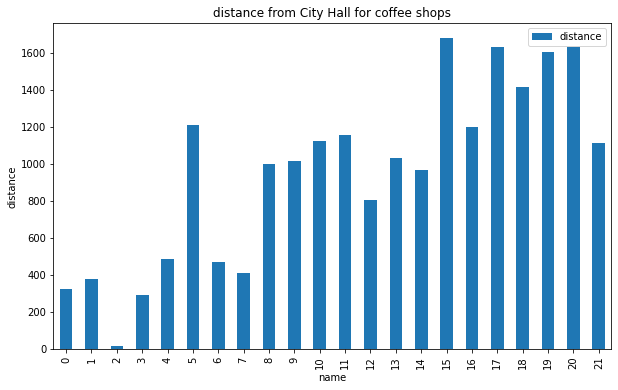

In [45]:
dist2.plot(kind='bar', figsize=(10, 6))
plt.xlabel('name')
plt.ylabel('distance')
plt.title('distance from City Hall for coffee shops')
plt.show()